In [225]:
from sklearn.cluster import KMeans
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from collections import defaultdict
%matplotlib inline
#https://towardsdatascience.com/spectral-clustering-aba2640c0d5b

{0: array([ 0.4485361 , -0.69988939]),
 1: array([ 1.        , -0.63229038]),
 2: array([ 0.64652797, -0.17550404]),
 3: array([-0.77640539,  0.18326889]),
 4: array([-0.93884793,  0.77377296]),
 5: array([-0.37981075,  0.55064195])}

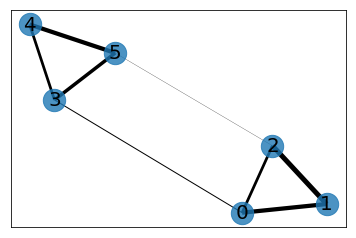

In [319]:
def makeCircleGraph():
    G=nx.Graph()
    G.add_edge(0,1)
    G.add_edge(0,2)
    G.add_edge(0,5)
    G.add_edge(0,8)
    G.add_edge(0,9)
    G.add_edge(1,2)
    G.add_edge(3,4)
    G.add_edge(3,5)
    G.add_edge(4,5)
    G.add_edge(5,6)
    G.add_edge(5,7)
    G.add_edge(6,7)
    G.add_edge(8,9)
    return G
def makeGraph2():
    G=nx.Graph()
    G.add_edge(0,1,weight=0.8)
    G.add_edge(0,2,weight=0.6)
    G.add_edge(0,3,weight=0.1)
    
    G.add_edge(1,2,weight=0.9)
    G.add_edge(2,5,weight=0.2)
    
    G.add_edge(3,4,weight=0.6)
    G.add_edge(3,5,weight=0.7)
    
    G.add_edge(4,5,weight=0.8)
    return G

def drawGraph(G,cluster=None,lineWidth=3,node_size=500,seed=None,minLine=1,maxLine=6):
    '''
    G:图对象
    cluster:对定点的分类结果,cluser[nodeId]表示类别
        cluster不是空,只有相同类型顶点之间才会画上边
    
    '''
    
    
    pos = nx.spring_layout(G,seed=seed)  # positions for all nodes
    colors=['r','g','b','y']

    if cluster is not None:
        groups=defaultdict(list)
        #draw node
        for node in G.nodes:
            c=cluster[node]
            nx.draw_networkx_nodes(G,pos,nodelist=[node],node_color=colors[c],node_size=node_size,alpha=0.8)
        #draw edge
        for u,v,_ in G.edges(data=True):
            if cluster[u]==cluster[v]:
                groups[cluster[u]].append((u,v))
        for c,edgelist in groups.items():
            nx.draw_networkx_edges(G,pos,edgelist,width=lineWidth,edge_color=colors[c],alpha=0.5)
    else:
        nx.draw_networkx_nodes(G, pos,node_size=node_size,alpha=0.8)
        #求出最小权重与最大权重
        minW,maxW=float('inf'),-1
        for u,v,d in G.edges(data=True):
            d=d['weight']
            if d>maxW:
                maxW=d
            if d<minW:
                minW=d
        #  线宽正比于权重
        for u,v,d in G.edges(data=True):
            d=d['weight']
            linesize=minLine+maxLine*(d-minW)/(minW-maxW)
            nx.draw_networkx_edges(G,pos,[(u,v)],aplha=0.5,width=linesize)
    # labels
    nx.draw_networkx_labels(G, pos, font_size=20, font_family='sans-serif')
    
    return pos

# G=makeCircleGraph()
G=makeGraph2()
drawGraph(G,seed=1000)

In [320]:
def graph2Matrix(G):
    '''
    根据G,返回一个邻接矩阵,A[i][j]表示从node i 到 node j的
    weight
    '''
    n=len(G.nodes)
    A=np.zeros((n,n))
    for nodeIdx,adj in G.adjacency():
        for adjIdx,w in adj.items():
            A[nodeIdx,adjIdx]=w['weight'] if 'weight' in w else 1
    return A
def LaplacianMatrix(A):
    '''
    传入邻接矩阵,A[i][j]表示从node i 到 node j的权重
    计算degress D,返回L=D-A
    '''
    D=np.diag(A.sum(axis=1))
    return D-A

def eig(L):
    '''
    计算L的特征值和特征向量,并按照升序排列
    返回S:r特征值
       V:n,r特征向量
    '''
    S,V=np.linalg.eig(L)
    sortIndex=np.argsort(S)
    S=S[sortIndex].real
    V=V[:,sortIndex].real
    return S,V
def proposalCluster(S,eps=0.2):
    '''
    
        eps:当某个特征值与他临近的差值大于eps时,
        这个特征值就是一个分界点,特征值的索引+1表示应该分类
        的个数
        
        返回建议分的类别,并且取出相应的
        特征,进行返回K
        
        
    '''
    
    K=1+np.where(S<eps)[0][-1]
    return K
def getCluster(K,eigValues):
    '''
    提取特征eigValues[:,1:K],然后运行分类算法
    '''
    features=eigValues[:,1:K]
    model=KMeans(n_clusters=K)
    model.fit(features)
    return model.labels_
    

classes: 2


{0: array([ 0.4485361 , -0.69988939]),
 1: array([ 1.        , -0.63229038]),
 2: array([ 0.64652797, -0.17550404]),
 3: array([-0.77640539,  0.18326889]),
 4: array([-0.93884793,  0.77377296]),
 5: array([-0.37981075,  0.55064195])}

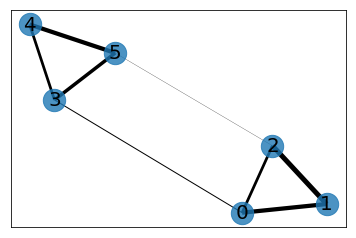

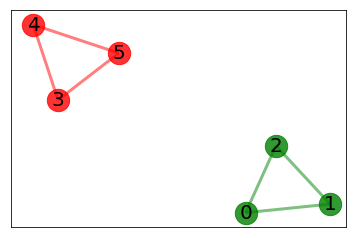

In [324]:
plt.figure()
seed=1000

drawGraph(G,lineWidth=3,seed=seed)

L=LaplacianMatrix(graph2Matrix(G))
S,V=eig(L)
K=proposalCluster(S,0.2)
print('classes:',K)
labels=getCluster(K,V)
plt.figure()
drawGraph(G,labels,lineWidth=3,seed=seed)